# Image Classification Example

<div class="alert alert-block alert-warning">
<b>Warning:</b> If `image_classifier` is not in the PYTHONPATH we need to insert it
</div>

In [1]:
try:
    import hydra_zen_example.image_classifier
except:
    import sys

    sys.path.insert(0, "..")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from hydra_zen import instantiate, to_yaml
from hydra_zen_example.image_classifier import configs

/home/justin_goodwin/.conda/envs/raiden/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Dataset

<div class="alert alert-block alert-warning">
<b>Data Location:</b> This experiment by default will store data in your home directory in the "/path/to/home/.data" directory. Change if you want to store somewhere else.
</div>

In [3]:
data_dir = str(Path.home() / ".data")

In [4]:
data = instantiate(configs.CIFAR10DataModule(batch_size=10, root=data_dir))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
x, y = next(iter(data.test_dataloader()))
x.shape

torch.Size([10, 3, 32, 32])

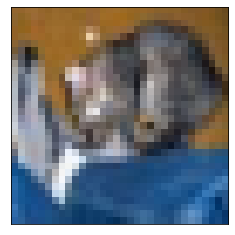

In [6]:
im = x[0].permute(1, 2, 0).numpy()
im = (im - im.min()) / (im.max() - im.min())
plt.subplots(subplot_kw=dict(xticks=[], yticks=[]))
plt.imshow(im)

## Model

<div class="alert alert-block alert-info">
<b>Note:</b> Uncomment the following line to see the model layers
</div>

In [7]:
# instantiate(configs.ResNet18(optim=configs.SGD))

## Train Using `launch`

<div class="alert alert-block alert-warning">
<b>PyTorch Lightning Warning:</b> `accelerator` must be set to `dp` inside a notebook,  `ddp` will not work
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell is set to only train for 1 epoch.  Change this value to 100 for full training.
</div>

In [7]:
from hydra_zen import launch
from run import Config, task_fn

training_job = launch(
    Config(data_dir=data_dir),
    task_fn,
    overrides=[
        "hydra.run.dir=outputs/training_test",
        "trainer.max_epochs=1",
        "trainer.accelerator=dp",
    ],
)
training_job.working_dir

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | predictor | Softmax          | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | metrics   | MetricCollection | 0     
3 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


'outputs/training_test'

### Test with pre-trained model

In [8]:
ckpt = str(sorted(Path(training_job.working_dir).glob("**/*.ckpt"))[-1].absolute())

job = launch(
    Config(data_dir=data_dir, ckpt_path=ckpt, testing=True),
    task_function=task_fn,
    overrides=[
        "trainer.accelerator=dp",
    ],
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Accuracy': 0.3869999945163727, 'Test/Loss': 1.619031548500061}
--------------------------------------------------------------------------------



## Launch Hydra Multirun using `launch`

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell is set to only train for 1 epoch.  Change this value to 100 for full training.
</div>

In [13]:
from hydra_zen import launch
from run import Config, task_fn

job = launch(
    Config(data_dir=data_dir),
    task_function=task_fn,
    overrides=[
        "hydra.sweep.dir=multirun/train_test",
        "model=resnet18,resnet50",
        "model/optim=sgd,adam",
        "trainer.max_epochs=1",
        "trainer.accelerator=dp",
    ],
    multirun=True,
)

[2021-10-21 00:06:34,593][HYDRA] Launching 4 jobs locally
[2021-10-21 00:06:34,594][HYDRA] 	#0 : model=resnet18 model/optim=sgd trainer.max_epochs=1 trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | predictor | Softmax          | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | metrics   | MetricCollection | 0     
3 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)



[2021-10-21 00:07:20,133][HYDRA] 	#1 : model=resnet18 model/optim=adam trainer.max_epochs=1 trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | predictor | Softmax          | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | metrics   | MetricCollection | 0     
3 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)



[2021-10-21 00:08:05,574][HYDRA] 	#2 : model=resnet50 model/optim=sgd trainer.max_epochs=1 trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | predictor | Softmax          | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | metrics   | MetricCollection | 0     
3 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)



[2021-10-21 00:09:51,643][HYDRA] 	#3 : model=resnet50 model/optim=adam trainer.max_epochs=1 trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | predictor | Softmax          | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | metrics   | MetricCollection | 0     
3 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


In [14]:
len(job[0])

4

In [15]:
job[0][0].working_dir

'multirun/2021-10-21/00-06-34/0'

In [16]:
print(to_yaml(job[0][0].cfg.model))

_target_: image_classifier.model.ResNet18Classifier
optim:
  _target_: hydra_zen.funcs.zen_processing
  _zen_target: torch.optim.sgd.SGD
  _zen_partial: true
  lr: 0.1
  momentum: 0.9
  dampening: 0
  weight_decay: 0
  nesterov: false
predict:
  _target_: torch.nn.modules.activation.Softmax
  dim: 1
criterion:
  _target_: torch.nn.modules.loss.CrossEntropyLoss
lr_scheduler:
  _target_: hydra_zen.funcs.zen_processing
  _zen_target: torch.optim.lr_scheduler.StepLR
  _zen_partial: true
  step_size: 50
  gamma: 0.1
  last_epoch: -1
  verbose: false
metrics:
  _target_: torchmetrics.collections.MetricCollection
  _convert_: all
  _args_:
  - _target_: builtins.dict
    Accuracy:
      _target_: torchmetrics.classification.accuracy.Accuracy



In [18]:
print(to_yaml(job[0][0].cfg.model.optim))

_target_: hydra_zen.funcs.zen_processing
_zen_target: torch.optim.sgd.SGD
_zen_partial: true
lr: 0.1
momentum: 0.9
dampening: 0
weight_decay: 0
nesterov: false



In [19]:
job[0][0].cfg.data.batch_size

256

In [20]:
isinstance(job[0][0].return_value, torch.nn.Module)

True